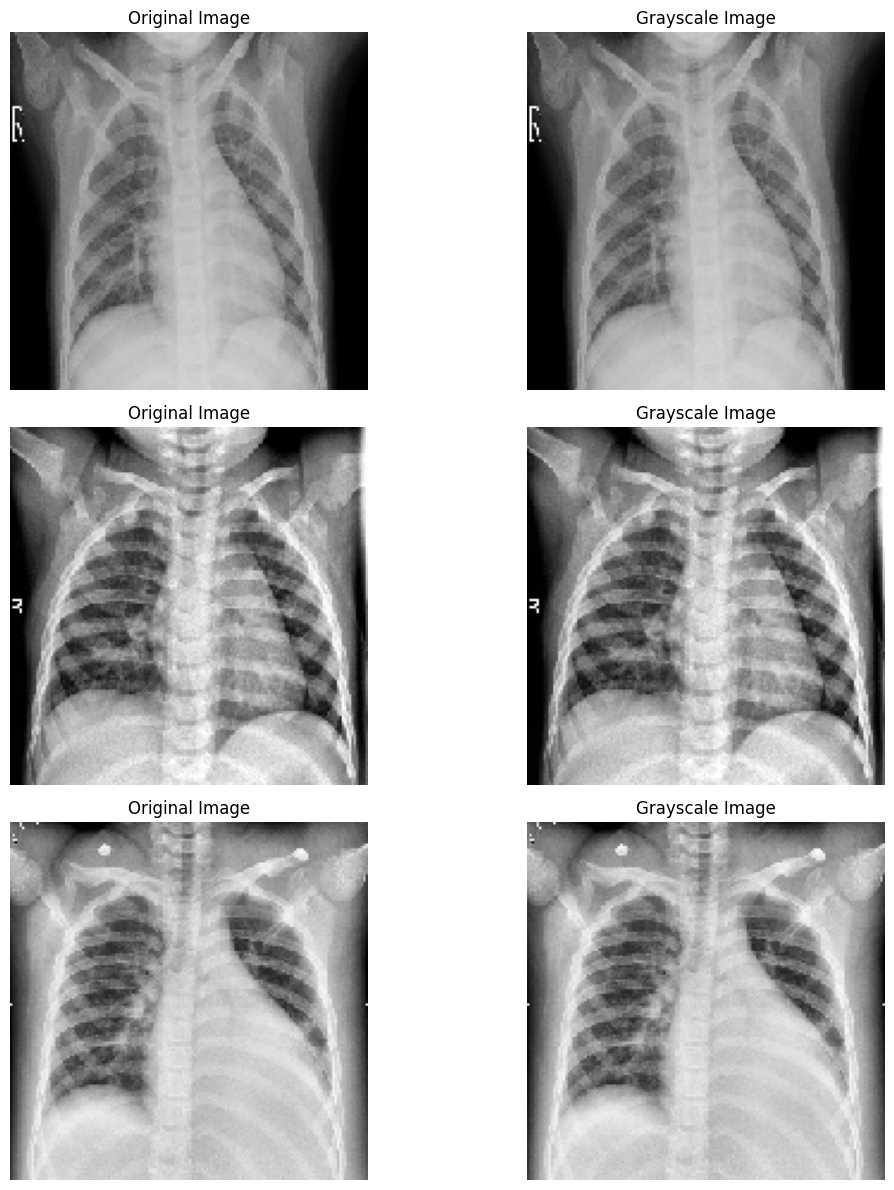

In [8]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Define the directories for the datasets
train_dir = '/kaggle/input/pnemonia/pnemonia/train'
val_dir = '/kaggle/input/pnemonia/pnemonia/val'

# Debugging: Check if the directories exist
if not os.path.isdir(train_dir):
    raise FileNotFoundError(f"Training directory not found: {train_dir}")

if not os.path.isdir(val_dir):
    raise FileNotFoundError(f"Validation directory not found: {val_dir}")

# Function to convert an image to grayscale
def convert_to_grayscale(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(150, 150))
    img_array = img_to_array(img)
    return img_array

# Select paths for sample images from each class
sample_image_paths = [
    os.path.join(train_dir, 'bacteria', '0(1).jpeg'),  # Replace with actual image filenames
    os.path.join(train_dir, 'normal', '3100.jpeg'),    # Replace with actual image filenames
    os.path.join(train_dir, 'virus', '2029.jpeg')      # Replace with actual image filenames
]

# Check if sample images exist
for image_path in sample_image_paths:
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Sample image file not found: {image_path}")

# Convert the selected images to grayscale
grayscale_images = [convert_to_grayscale(image_path) for image_path in sample_image_paths]

# Plot the original and grayscale images side by side
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for i, image_path in enumerate(sample_image_paths):
    original_img = load_img(image_path, target_size=(150, 150))
    grayscale_img = grayscale_images[i]

    axs[i, 0].imshow(original_img)
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(np.squeeze(grayscale_img), cmap='gray')
    axs[i, 1].set_title('Grayscale Image')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


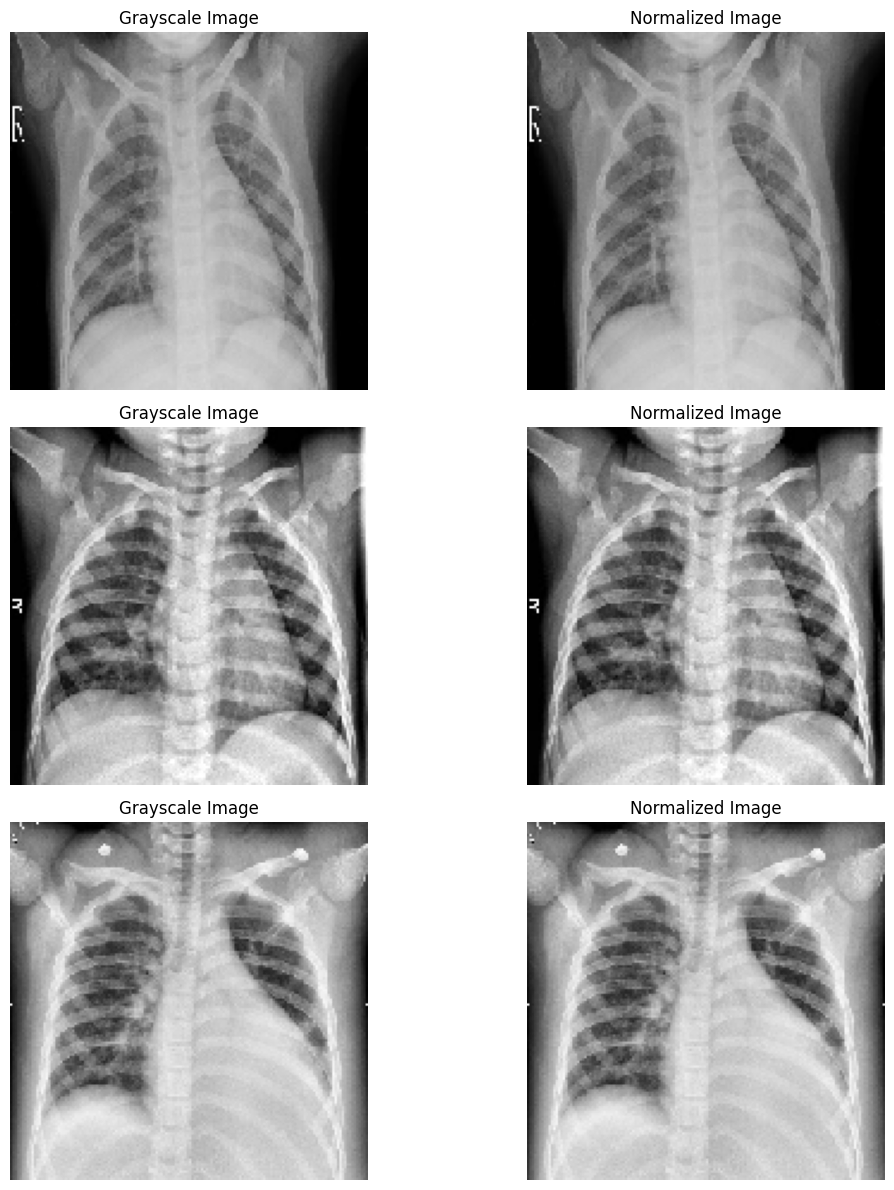

In [9]:
# Function to normalize an image array to the range [0, 1]
def normalize_image(img_array):
    normalized_img_array = img_array / 255.0
    return normalized_img_array

# Normalize the grayscale images
normalized_images = [normalize_image(img) for img in grayscale_images]

# Plot the grayscale and normalized images side by side
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for i, grayscale_img in enumerate(grayscale_images):
    normalized_img = normalized_images[i]

    axs[i, 0].imshow(np.squeeze(grayscale_img), cmap='gray')
    axs[i, 0].set_title('Grayscale Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(np.squeeze(normalized_img), cmap='gray')
    axs[i, 1].set_title('Normalized Image')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


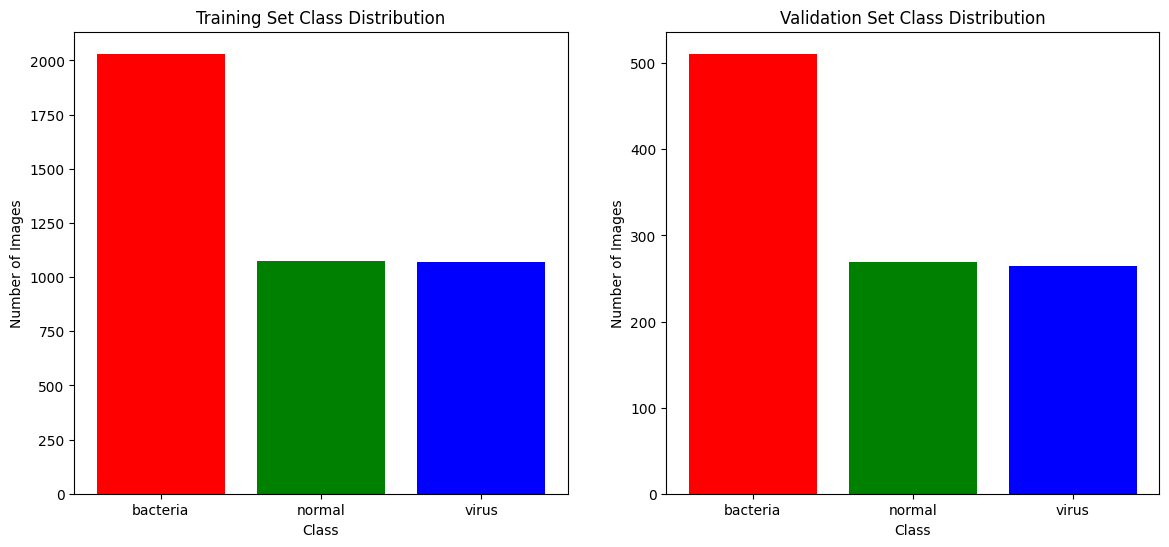

In [10]:
# Function to count the number of images in each class directory
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count the number of images in training and validation datasets
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)

# Plot the class distribution in training and validation sets
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution for the training set
ax[0].bar(train_counts.keys(), train_counts.values(), color=['red', 'green', 'blue'])
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

# Plot the distribution for the validation set
ax[1].bar(val_counts.keys(), val_counts.values(), color=['red', 'green', 'blue'])
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.show()


In [11]:
# Custom callback to print training metrics at the end of each epoch
class PrintMetrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - "
              f"loss: {logs['loss']:.4f} - "
              f"accuracy: {logs['accuracy']:.4f} - "
              f"val_loss: {logs['val_loss']:.4f} - "
              f"val_accuracy: {logs['val_accuracy']:.4f}")

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 4174 images belonging to 3 classes.
Found 1044 images belonging to 3 classes.


In [12]:
# Load the ResNet50 model with pre-trained weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Construct the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Typically lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model with fine-tuning
history = model.fit(
    train_generator,
    epochs=10,  # Fine-tune for fewer epochs initially
    validation_data=val_generator,
    callbacks=[PrintMetrics()]
)
# Unfreeze some layers and continue training if needed
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers, for example
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001),  # Even lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history = model.fit(
    train_generator,
    epochs=40,  # Continue fine-tuning
    validation_data=val_generator,
    callbacks=[PrintMetrics()]
)
# Save the fine-tuned model
model.save('resnet50_fine_tuned_model.h5')
# Function to predict image class
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    return predicted_class

# Example usage:
# img_path = 'path_to_image.jpg'
# print(predict_image(img_path))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4195 - loss: 1.1412Epoch 1 - loss: 1.1219 - accuracy: 0.4250 - val_loss: 1.0279 - val_accuracy: 0.4895
131/131 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.4196 - loss: 1.1410 - val_accuracy: 0.4895 - val_loss: 1.0279
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4644 - loss: 1.0820Epoch 2 - loss: 1.0660 - accuracy: 0.4708 - val_loss: 1.0015 - val_accuracy: 0.4923
131/131 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.4644 - loss: 1.0819 - val_accuracy: 0.4923 - val_loss: 1.0015
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4816 - loss: 1.0401Epoch 3 - loss: 1.0407 - accuracy: 0.4804 - val_loss: 0.9863 - val_accuracy: 0.5086
131/131 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.4816 - loss: 1.0401 - val_accuracy: 0.5086 - val_loss: 0.9863
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5187 - loss: 1.0098Epoch 4 - loss: 1.0123 - accuracy: 0.5010 - val_loss: 0.9691 - val_ac

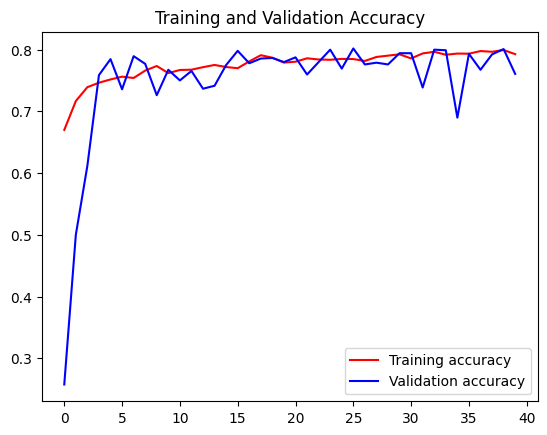

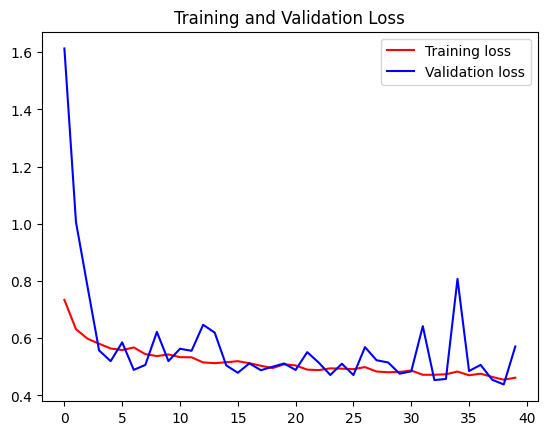

In [13]:
import matplotlib.pyplot as plt

# Extract accuracy and loss data from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


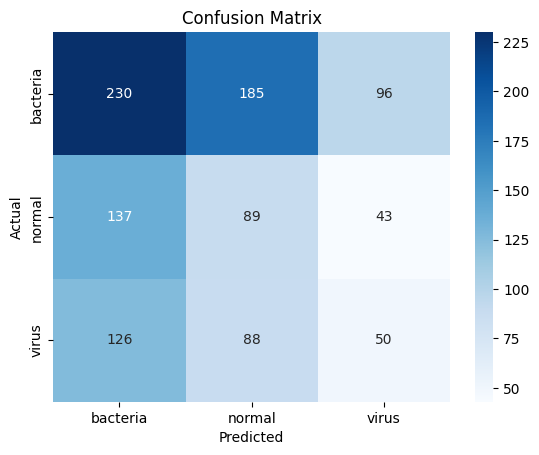

Classification Report:
               precision    recall  f1-score   support

    bacteria       0.47      0.45      0.46       511
      normal       0.25      0.33      0.28       269
       virus       0.26      0.19      0.22       264

    accuracy                           0.35      1044
   macro avg       0.33      0.32      0.32      1044
weighted avg       0.36      0.35      0.35      1044

Precision: 0.3586
Recall: 0.3534
F1 Score: 0.3528


In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Evaluate the model on the validation set
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Compute and plot the confusion matrix
cm = confusion_matrix(val_generator.classes, y_pred)
cm_plot_labels = ['bacteria', 'normal', 'virus']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
classification_report_str = classification_report(val_generator.classes, y_pred, target_names=cm_plot_labels)
precision = precision_score(val_generator.classes, y_pred, average='weighted')
recall = recall_score(val_generator.classes, y_pred, average='weighted')
f1 = f1_score(val_generator.classes, y_pred, average='weighted')

print("Classification Report:\n", classification_report_str)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:

# Function to preprocess and predict image class for a single image
def preprocess_and_predict(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    return predicted_class

# Function to predict image classes for multiple images in a folder and plot them
def predict_and_plot_images_in_folder(folder_path):
    class_labels = {0: 'bacteria', 1: 'normal', 2: 'virus'}
    plt.figure(figsize=(15, 10))
    i = 0
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        if os.path.isfile(img_path) and img_name.lower().endswith(('png', 'jpg', 'jpeg')):
            predicted_class = preprocess_and_predict(img_path)
            plt.subplot(4, 4, i + 1)  # Adjust subplot grid size as needed
            plt.imshow(image.load_img(img_path))
            plt.title(f"{img_name}\n{class_labels[predicted_class]}", color='yellow')
            plt.axis('off')
            i += 1
            if i == 16:  # Adjust the number of images to display
                break
    plt.tight_layout()
    plt.show()

# Example usage:
img_folder_path = '/kaggle/input/validation'  # Replace with the path to your folder
predict_and_plot_images_in_folder(img_folder_path)